In [ ]:
# | hide
%pip install -e ../..

In [ ]:
# | hide
import copy
from pathlib import Path

import clay.embeddings
import matplotlib.pyplot as plt
import numpy as np

# Clay Model v0 release
> Documentation for the Clay Model v0 release.

# Model Overview
This document outlines the v0 release of our deep learning model designed for Earth Observation (EO), leveraging Sentinel satellite data. The model aims to provide advanced insights and analysis for various EO applications.


## Model Card
We follow the [Model Card Toolkit](https://modelcards.withgoogle.com/about). It provides a summary of the model's purpose and behavior, as well as information on the dataset it was trained on and the people and organizations involved in its creation. The model card is intended to help enable responsible use of AI systems by documenting their use cases and limitations.

## Model Details
- Name: Clay Model
- Version: 0.1
- Type: Geospatial Visual Transformer trained with a [MAE](https://arxiv.org/abs/1905.09272) objective.
- Training Data: ~1M spatiotemporal locations statistically sampled to contain a variety of land cover types. For each location, the bundle has: 10 Sentinel-2 bands, 2 Sentinel-1 bands and a [DEM](#).
- Domain: Earth Observation
- Author: Clay.foundation
- Contact: info@madewithclay.org
- Release Date: 2023-12-31
- License: For the code, [Apache 2.0](../../LICENSE). For the trained model [OPEN RAIL-M](../../LICENSE-MODEL.md)



## Intended Use

This model is intended as a foundational EO model. It can directly be used to create semantic embeddings, or be finetuned for classification or regression tasks. It can also be finetuned with other input data. 

It is inteded to be used by non-profits, researchers, journalists, developers and data scientists. It is also intended to be used by commercial entities. Hence it is released with an open data and only trained with fully open data.

# Trainning Data Description


## Training Information

The trainning Objective is a Masked Autoencoder. We mask up to 70% of the input pixels across all bands (same location across bands) and train the model to predict the masked pixels.

- **Hyperparameters**: 
    * Effective Batch Size is `200`. (Batch per GPU - `10`, and `4` GPUs. Gradient accumulation every `5` batches, so `4* 10 * 5` => `200`.
    * Learning rate: Cosine Decay with Warm Restarts as our LR scheduler.
    * Weight decay: TBD
    * Number of epochs: `20` TBD
    * Optimizer: AdamW ? TBD

**We do not use Data Augmentation**. With learnable location and time embeddgins we cannot use data augmentation. We do not use any other regularization techniques. We not use MixUp or CutMix, as it would need a complex tweak to carry over the metadata (location and time) to the mixed up images.


## Performance Metrics
The model shows the following performance characteristics: 
- Accuracy: [Value]
- Precision: [Value]
- Recall: [Value]

## Known Limitations
- The model is trained on Sentinel data only.
- Sentinel data only covers land and coastal waters. 
- We only train on a ver small sample of the Sentinel archives, both in terms of spatial coverage and time. 
- We do not train on the poles, and we do not train on open ocean, nor ocean nor atmospheric data. 
- We do not train on night time data. 
- We do not explicitly include extreme events in the training data. 
- For `v0` we only train at most 3 different times per location.

### Clouds and other source of "noise":
In most EO applications clouds, cloud shadows, smog, atmospheric scattering, mid-air planes and other non-ground registrations are considered noise. We explicitly filter our clouds on our chips, but small clouds and their shadows might be present. As we increase the number of observations per location, and bands, we expect the model to learn to ignore single events but register patterns (places that are often cloudy or with smog).

## Known Biases: 
[Discuss any biases]

## Ethical Considerations

Our goal is to lower the barrier to use EO data for biodiversity and climate change mitigation and adaptation. 

We focus on the undifferentiated baseline compute for most EO applications with a fully permissive license. This way we can encourage downstream users, both non-profit and for-profit to leapfrog their AI4EO services *made with Clay*, our independent, benchmarked, operational, open model. We aim thus to reducing the overall carbon footprint of EO applications, while providing state of the art baseline models for everyone.



# Training Specifications
## Training Process

### 1. Data Factory

We use [Microsoft Planetary Computer](#) to pull all the data. [Code](https://github.com/Clay-foundation/model/blob/main/scripts/datacube.py)

For `v0` we used [ESA's Worldcover](#) 2021 to create a statistically representative sample of the Earth's land cover. [Code](https://github.com/Clay-foundation/model/blob/main/scripts/landcover.sh). 

Our [sampling function](https://github.com/Clay-foundation/model/blob/main/scripts/landcover.py#L149) aims to select ~1000 MGRS tiles, with `200` samples from the `2000` most land-cover diverse tiles,  `50` samples from the `1000` single lanc cover class for all categories except water ( urban, wetland, mangroves, moss, cropland, trees, shrubland, grassland, bare, snow). For coastal data we select `100` samples from all tiles with between 30% an 70% water.

For each selected MGRS tile, we split it into [`512x512`](https://github.com/Clay-foundation/model/blob/main/scripts/tile.py#L21) chips. We filter out chips with more than [`30%`](https://github.com/Clay-foundation/model/blob/main/scripts/tile.py#L23) clouds or bad pixels.

We save each band into a different `.tif` file following the schema `claytile_{mgrs}_{date}_v{version}_{counter}.tif` where `mgrs` is the MGRS tile, `date` is the date of the observation, `version` is the version of the sampling strategy and `counter` is the counter of the chip in the tile [from left to right, from top to bottom].

Finally we save that into `S3` under the version of the sampling strategy folder.

Clay model `v0` uses `v2` sampling strategy, and corresponds to `1,045,224` chips (each a ``.tif`` file with 13 bands) and `6.4 TB`.

The exact list of files used for `v0` is [here](https://gist.github.com/brunosan/62247e5dc79684bdaca11cefae679e90) [5Mb zipped, 88Mb `.txt` list], generated using:
```bash 
aws s3 ls s3://clay-tiles-02/ --recursive --human-readable --no-paginate --summarize > s3_listing_data_v2_model_v0.txt
```


### 2. Training Loop

TBD

### 3. Embeddings creation.

As standard practice, and since we already have all the data prepared, we create embeddings for all the trainning data. We use the same model, but we remove the masking. 

We use the same trainning data source:

```python
python trainer.py predict --ckpt_path=checkpoints/last.ckpt \
                          --data.batch_size=1024 \
                          --data.data_dir=s3://clay-tiles-02 \
                          --trainer.limit_predict_batches=1
```

## Computational Resources
- **Compute**: Trained on AWS `g5.12xlarge` instance, which has 4 A10G GPUs (24 GB VRAM in each).
- **Training Time**: Each epoch takes ~12 hour. The model was trained for 20 [CONFIRM] epochs.


## Data Splits
- Training Data: [Percentage]
- Validation Data: [Percentage]
- Test Data: [Percentage]

## Validation Methods
Description of the validation process and results achieved.
Model Exploration

## Model Exploration

TBD

## Embeddings Exploration

The Embeddings in our model are the output of the `Transformer` encoder. It's the "semantic" bottleneck betwen the encoder and the decoder. The encoder needs to abstract the semantics of the image into a single vector, so the decoder can reconstruct the image from that vector.

These embeddings start as random vectors and slowly converge to a meaningful representation of the input data. 

Let's read all the embeddings from the trainning data and see how they look like.


In [ ]:
embeddings_path = Path("/home/brunosan/data/Clay/clay-vector-embeddings-v001")
embeddings = clay.embeddings.EmbeddingsHandler(embeddings_path)
embeddings.load_data()


100%|██████████| 1088/1088 [00:04<00:00, 237.36it/s]


Total rows: 947019
 Merging dataframes...
Done!
 Total rows:  947019


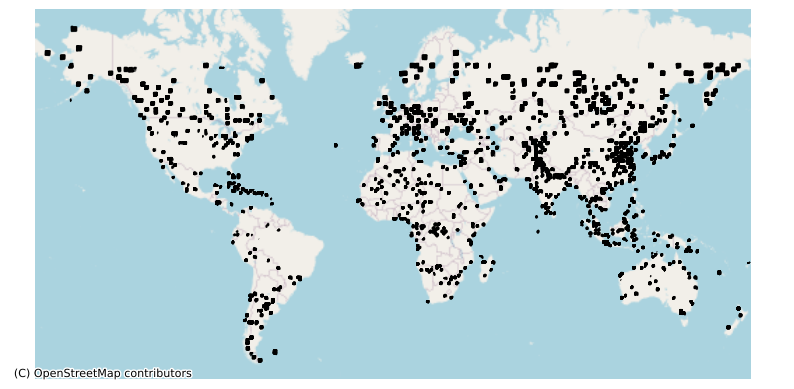

In [ ]:
embeddings.plot(max_rows=None)

These are some properties we expect from the embeddings:

* The "length" (L2norm) and distribution of lengths is a one proxy for how much informationm and how much range of semantics they might contain. 
* We expect the embeddgins to cluster when representing different places with similar semantics. We can use [tNSE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) to reduce the dimensionality of the `712` dimensions manyfold into 2D while trying to keep the clustering.
* If we take visually similar chips, they should have a smaller distance between them than chips that are visually different. We can use [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity) to measure the distance between two embeddings.




### L2norm distribution 

In [ ]:
embeddings.gdf["l2norm"] = embeddings.gdf["embeddings"].apply(
    lambda x: np.linalg.norm(x, ord=2)
)

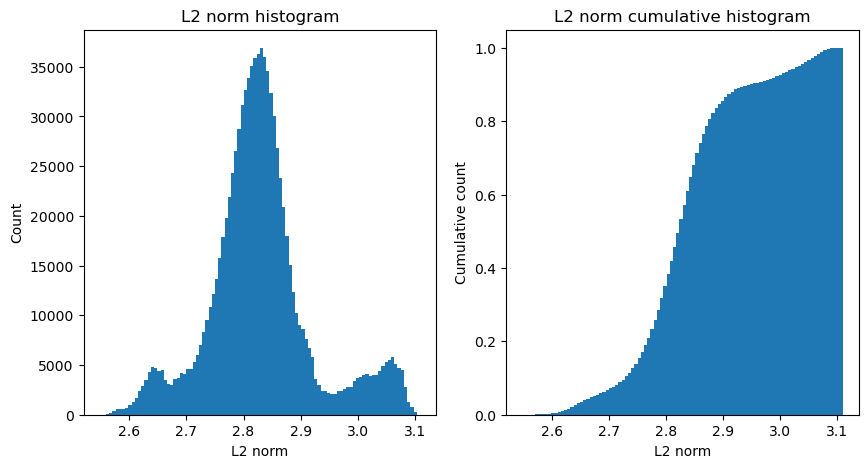

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].set_title("L2 norm histogram")
ax[0].set_xlabel("L2 norm")
ax[0].set_ylabel("Count")
ax[0].hist(embeddings.gdf["l2norm"], bins=100)
ax[1].set_title("L2 norm cumulative histogram")
ax[1].set_xlabel("L2 norm")
ax[1].set_ylabel("Cumulative count")
ax[1].hist(embeddings.gdf["l2norm"], bins=100, density=True, cumulative=True);

We can see that ~80% of the embeddings are between `2.7` and `2.9`, with two peaks on the edges. We can explore samples from the tails to see what is going on.


In [ ]:
left_peak_range = [2.6, 2.7]
right_peak_range = [2.95, 3.1]

print(f"embeddings: {len(embeddings.gdf)}")

left_tails = copy.deepcopy(embeddings)
left_tails.gdf = embeddings.gdf[
    (embeddings.gdf["l2norm"] > left_peak_range[0])
    & (embeddings.gdf["l2norm"] < left_peak_range[1])
].copy()

right_tails = copy.deepcopy(embeddings)
right_tails.gdf = embeddings.gdf[
    (embeddings.gdf["l2norm"] > right_peak_range[0])
    & (embeddings.gdf["l2norm"] < right_peak_range[1])
].copy()

print(f"left_tails: {len(left_tails.gdf)}")
print(f"right_tails: {len(right_tails.gdf)}")

embeddings: 947019
left_tails: 60581
right_tails: 94057


## Benchmarking

# Benchmark dataset labels

A benchmark dataset is a collection of data used for evaluating the performance
of algorithms, models or systems in a specific field of study. These datasets
are crucial in providing a common ground for comparing different approaches,
allowing researchers to assess the strengths and weaknesses of various methods.
For Clay, we evaluate our model on benchmark datasets with suitable downstream
tasks.

For our initial benchmark dataset, we've implemented the
[Cloud to Street - Microsoft flood dataset](https://beta.source.coop/repositories/c2sms/c2smsfloods/description).
It is what we will use in our initial linear probing experiments and
evaluation of finetuning on a downstream task. The task itself is
[segmentation](https://paperswithcode.com/task/semantic-segmentation) of water
pixels associated with recorded flood events.

The original dataset consists of 2/3 of our Foundation model's datacube inputs
(Sentinel-1 and Sentinel-2) along with raster water mask labels for both
sensors. Each image is 512x512 pixels in terms of width and height. The
original Sentinel-2 images are L1C, which is Top-of-Atmosphere reflectance. We
are training Clay with surface reflectance, however, so we ultimately used the
geospatial bounds from the GeoTIFF and image timestamp (from the granule name)
to query
[Microsoft Planetary Computer's STAC API for L2A (Bottom-of-Atmosphere a.k.a. "surface reflectance") Sentinel-2](https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a)
scenes in the same time and space, with the same channels expected by Clay. We
then followed the same `datacube` creation logic to generate datacubes with
Sentinel-1 VV and VH and the Copernicus digital elevation model (DEM). We also
ensured that the Sentinel-1 data was within a +/- 3 day interval of each
reference Sentinel-2 scene (same method used by the benchmark dataset authors)
and that the Sentinel-1 data was indeed already included in the bechmark
datasets list of granules. The datacubes generated have all three inputs
matching the exact specs of the Foundation model's training data, at 512x512
pixels.

Here is an example of a datacube we generated for the dataset:

![datacube](https://github.com/Clay-foundation/model/assets/23487320/94dffcf5-4075-4c17-ac96-01c11bcb299b)

The images left to right show a true color representation of the Sentinel-2
scene, the Sentinel-1 VH polarization and the digital elevation model.

![gt](https://github.com/Clay-foundation/model/assets/23487320/4ac92af7-6931-4249-a920-7d29453b9b31)

Here we have something similar, but this time just the Sentinel-1 and
Sentinel-2 scenes with the Sentinel-1 water mask (ground truth) overlaid.

Last note on this benchmark dataset that we've adapted for Clay, we made sure
to preserve the metadata for timestamp and geospatial coordinates in the
datacube such that we can embed information in the way that the Clay Foundation
model expects. We also preserve the flood event information too, for analysis
during finetuning.

The script for generating these datacubes is at
https://github.com/Clay-foundation/model/blob/c2smsfloods_benchmark_datapipeline/scripts/datacube_benchmark.py.
You'll need an AWS account and Microsoft Planetary Computer API Key to run
this. The data is queried from Microsoft Planetary Computer STAC APIs, read and
processed in memory, and the datacubes are written directly to AWS S3.
